In [1]:
from pyspark import SparkContext, SparkConf
cf = SparkConf()
cf.set("spark.submit.deployMode","client")
sc = SparkContext.getOrCreate(cf)
from pyspark.sql import SparkSession
spark = SparkSession \
	    .builder \
	    .appName("TransitTrends-Taxi-Data-Cleaning") \
	    .config("spark.some.config.option", "some-value") \
	    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/22 01:09:56 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/04/22 01:09:56 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/04/22 01:09:56 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/04/22 01:09:56 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [2]:
from pyspark.sql.functions import lit

# importing green cabs data, dropping unnecessary coloumns and renaming few coloumns to match yellow cabs data:
#green_cabs_df = spark.read.csv(path='/shared/TAXI_SAMPLE/GREEN_CABS/',header=True, inferSchema= True).withColumn("taxi_type", lit("green")).drop("trip_type").withColumnRenamed("lpep_dropoff_datetime", "tpep_dropoff_datetime").withColumnRenamed("lpep_pickup_datetime", "tpep_pickup_datetime")
green_cabs_df = spark.read.parquet("/shared/TAXI/GREEN_CABS/").withColumn("taxi_type", lit("green")).drop("trip_type").withColumnRenamed("lpep_dropoff_datetime", "tpep_dropoff_datetime").withColumnRenamed("lpep_pickup_datetime", "tpep_pickup_datetime")

# importing yellow cabs data:
#yellow_cabs_df = spark.read.csv(path='/shared/TAXI_SAMPLE/YELLOW_CABS/',header=True, inferSchema= True).withColumn("taxi_type", lit("yellow"))
yellow_cabs_df = spark.read.parquet("/shared/TAXI/YELLOW_CABS/").withColumn("taxi_type", lit("yellow"))

# note: sometime there might be .ipynb checkpoints in /shared/GREEN_CABS folder. remove them hdfs before running this cell

In [3]:
print(green_cabs_df.count())
green_cabs_df.show(100)

9944318


+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|congestion_surcharge|taxi_type|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+---------+
|       2| 2018-12-21 15:17:29|  2018-12-21 15:18:57|                 N|       1.0|         264|         264|            5.0|          0.0|        3.0|  0.5|    0.

In [4]:
print(yellow_cabs_df.count())
yellow_cabs_df.show(100)

179807942
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|taxi_type|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+
|       1| 2019-03-01 00:24:41|  2019-03-01 00:25:31|            1.0|          0.0|       1.0|                 N|         145|         145|        

In [5]:
# combining yellow and green cabs data into a single dataset:
cabs_df = yellow_cabs_df.union(green_cabs_df)
# dropping unnnecessary coloumns:
cabs_df = cabs_df.drop("store_and_fwd_flag")

In [6]:
print(cabs_df.count())
cabs_df.show(100)

189752260


+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|taxi_type|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+
|       1| 2019-03-01 00:24:41|  2019-03-01 00:25:31|            1.0|          0.0|       1.0|       145.0|       145.0|         2.0|        2.5|  0.5|    0.5|       0.0|         0.0|                  0.3|         

In [7]:
import pyspark.sql.functions as F

In [8]:
# Clean the column names
cabs_df = cabs_df.select([F.col(column).alias(column.strip()) for column in cabs_df.columns])
cabs_df.show(100)

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|taxi_type|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+
|       1| 2019-03-01 00:24:41|  2019-03-01 00:25:31|            1.0|          0.0|       1.0|       145.0|       145.0|         2.0|        2.5|  0.5|    0.5|       0.0|         0.0|                  0.3|         

In [9]:
# Remove duplicates
cabs_df = cabs_df.dropDuplicates(["taxi_type","total_amount","tpep_pickup_datetime","tpep_dropoff_datetime","pulocationid","dolocationid", "passenger_count", "vendorid", "trip_distance"])
print(cabs_df.count())

189739011


In [10]:
#Filter for data in 2019-2021, removing the last week of 2018 from the dataset
cabs_df = cabs_df.filter(F.year("tpep_pickup_datetime").isin([2019, 2020, 2021]))
print(cabs_df.count())

149240747


In [11]:
from pyspark.sql.functions import concat
cabs_df = cabs_df.withColumn("pickup_datetime", cabs_df["tpep_pickup_datetime"].cast("timestamp"))
cabs_df = cabs_df.withColumn("month", F.month(cabs_df["pickup_datetime"])).withColumn("year", F.year(cabs_df["pickup_datetime"]))

In [12]:
monthly_records = cabs_df.select("month","year")
#cabs_df = monthly_records.withColumn("month/year", concat(F.col("month"), F.lit("/"), F.col("year"))).drop("month","year")

In [13]:
monthly_records.show(100)

+-----+----+
|month|year|
+-----+----+
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    2|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    2|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    2|2019|
|    3|2019|
|    3|2019|
|    3|2019|

In [14]:
from pyspark.sql.functions import count,asc

count_df = monthly_records.groupBy('year','month').agg(count('*').alias('count')).orderBy(asc('year'), asc('month'))
count_df.show(100)

+----+-----+-------+
|year|month|  count|
+----+-----+-------+
|2019|    1|8368407|
|2019|    2|7664688|
|2019|    3|8509397|
|2019|    4|8043798|
|2019|    5|8144005|
|2019|    6|7477556|
|2019|    7|6781087|
|2019|    8|6522781|
|2019|    9|7016641|
|2019|   10|7690494|
|2019|   11|7327314|
|2019|   12|7351543|
|2020|    1|6839954|
|2020|    2|6698227|
|2020|    3|3230876|
|2020|    4| 273644|
|2020|    5| 405807|
|2020|    6| 612940|
|2020|    7| 872692|
|2020|    8|1088348|
|2020|    9|1428878|
|2020|   10|1776382|
|2020|   11|1597523|
|2020|   12|1545056|
|2021|    1|1446279|
|2021|    2|1436265|
|2021|    3|2008961|
|2021|    4|2258149|
|2021|    5|2595260|
|2021|    6|2920952|
|2021|    7|2905788|
|2021|    8|2871791|
|2021|    9|3059485|
|2021|   10|3574376|
|2021|   11|3581125|
|2021|   12|3314278|
+----+-----+-------+



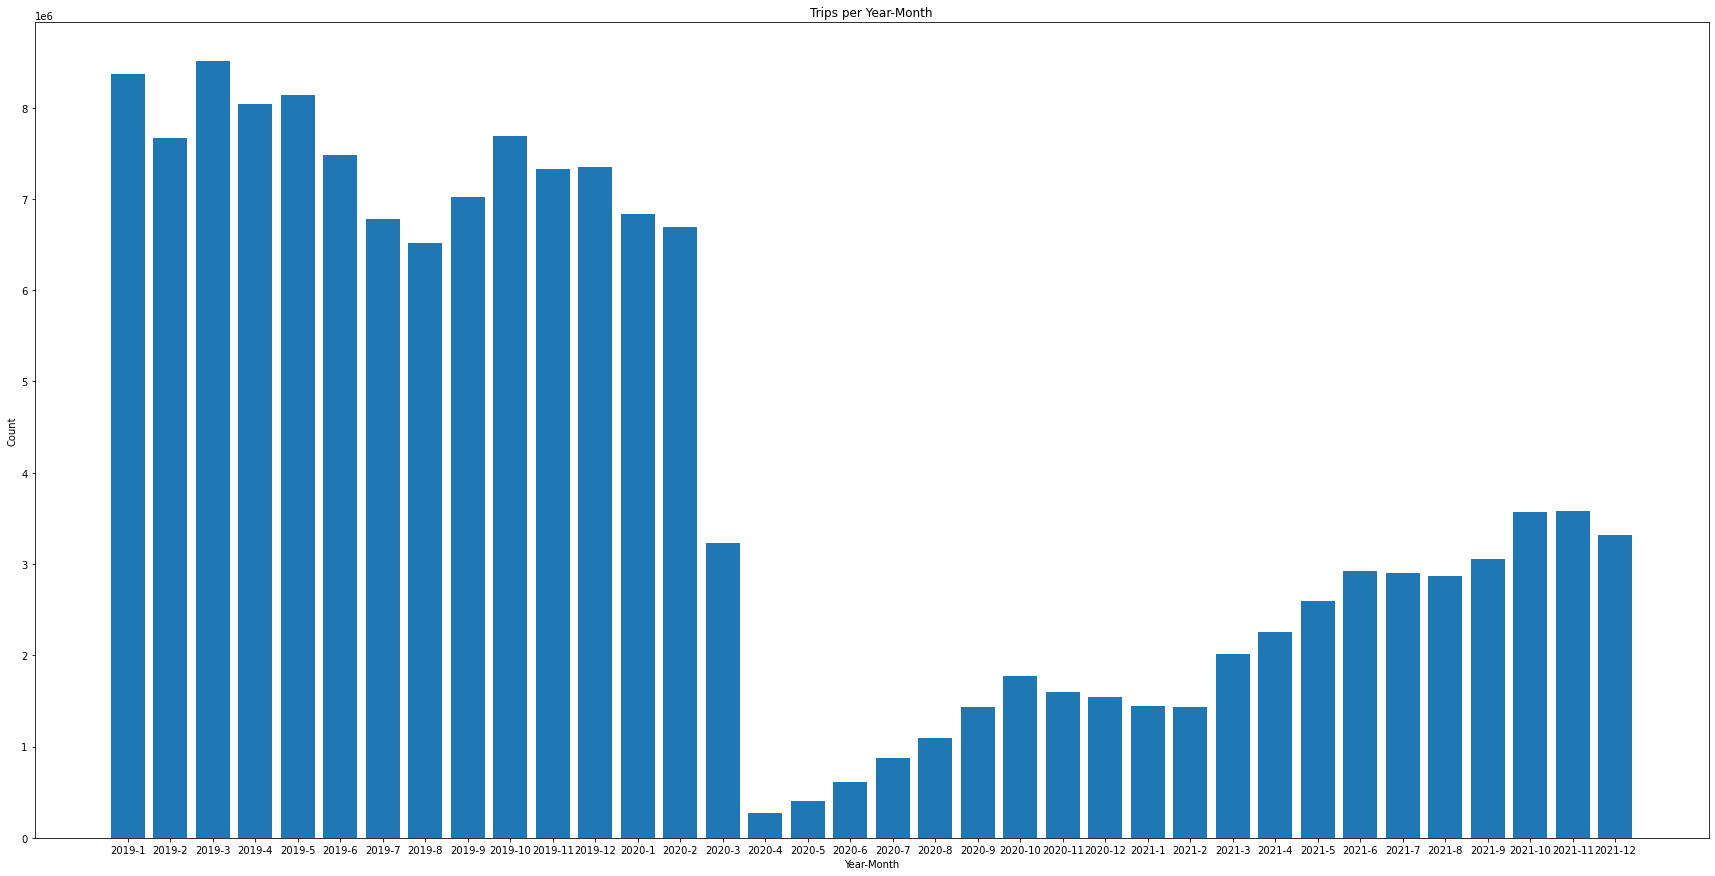

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to Pandas DataFrame
pd_df = count_df.toPandas()

plt.figure(figsize=(30, 15))

# Create the bar plot using matplotlib
plt.bar(pd_df['year'].astype(str) + '-' + pd_df['month'].astype(str), pd_df['count'])

# Set the title and axis labels
plt.title('Trips per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.savefig('trips_per_month.png')
# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>